In [26]:
using Plots
using QuadGK
using NLopt
using SpecialFunctions
using NLsolve
using Statistics
include("../../scaling_CGS.jl")

print_all_CGS (generic function with 2 methods)

In [746]:
#---------- Two Steam Setup ----------
base = BaseUnits("CGS")

electron_mass_scaling = 1e0
charge_scaling = 1e0
eps_0_scaling = 1e0
mu_0_scaling = 1e0

scale_base_units(base, eps_0_scaling, mu_0_scaling, charge_scaling, electron_mass_scaling)

mass_density_scale = 1.673532836356e-14
#length_scale       = 227.71078654314857#ion skin depth
length_scale       = 5.314093711399421 # electron skin depth
#time_scale         = 1.1137516851221212e-9 # here omega_e = 2pi in code units -> means 1 plasma oscillation is 1 code unit
time_scale         = 1.7725908606411373e-10 # here omega_e=1 in code units -> means 1 plasma oscillation is 2pi code unit


#length= 227.71078654314857 #ion skin depth
length = 5.314093711399421 # electron skin depth
number_density=1e10
B_flux=10
temperature   = 592989.85 # Corresponds to v_t_e = 0.01*c  = 0.05*V_0
#temperature   = 2.3719594179263036e6 # Corresponds to v_t_e = 0.1*V_0  for V_0 = 0.2*c 
#temperature   = 2.3719594179263036e6 * 2.0^2

temperature_e = temperature
temperature_p = temperature



scaling = ScalingCGS(base,
                number_density, length, temperature, temperature_e, temperature_p, B_flux,
                length_scale, mass_density_scale, time_scale)

ds = 0.0025
per_cell = 125

set_macro_particle_weights(scaling, ds, per_cell);
print_all_CGS(scaling)


 Maxwell Lorents Factors used in code:
 k_E =                                             =  1.0000e+00 
 k_B =                                             =  1.0000e+00 
 k_F =                                             =  1.0000e+00 
 k_D =                                             =  1.0000e+00 
 k_M =                                             =  1.0000e+00 
 k_H =                                             =  1.0000e+00 

 Macro particle weights:
                          ds =                     =  2.5000e-03 
                    per_cell =                     =  1.2500e+02 
               weight_scaled =                     =  1.8758e+02 
 weight_scaled_mass_electron =                     =  6.8040e-14 
   weight_scaled_mass_proton =                     =  1.2493e-10 
        weight_scaled_charge =                     =  8.2268e-13 
                 rho_n_ratio =                     =  1.5007e+12 

 Fundamental physical constants:
        Gravitational Constant [ cm^3 g^-1

In [28]:
scaling.inter_dist_code

8.734488109714682e-5

In [29]:
1 / scaling.number_density_code

6.663653002095697e-13

In [30]:
592989.85

592989.85

In [31]:
c = scaling.c_real


m_i = scaling.m_p_real
m_e = scaling.m_e_real


t = scaling.temperature_real


n_i = scaling.number_density_real
n_e = scaling.number_density_real

k_B = scaling.k_B_real

V_0 = scaling.c_real * 0.2

v_t_e = scaling.v_thermal_e_real
v_t_p = scaling.v_thermal_p_real


omega_e = scaling.electron_plasma_freq_real
omega_p = scaling.proton_plasma_freq_real

debye_e = scaling.debye_len_real
debye_i = scaling.v_thermal_p_real / scaling.proton_plasma_freq_real


skin_depth = scaling.skin_depth_p_real

println(v_t_e / V_0)

0.1


In [32]:
scaling.skin_depth_real

5.314093711399421

In [747]:
c = scaling.c_code


m_i = scaling.m_p_code
m_e = scaling.m_e_code


t = scaling.temperature_code


n_i = scaling.number_density_code
n_e = scaling.number_density_code

k_B = scaling.k_B_code

V_0 = scaling.c_code * 0.2

v_t_e = scaling.v_thermal_e_code
v_t_p = scaling.v_thermal_p_code


omega_e = scaling.electron_plasma_freq_code
omega_p = scaling.proton_plasma_freq_code

debye_e = scaling.debye_len_code
debye_i = scaling.v_thermal_p_code / scaling.proton_plasma_freq_code


skin_depth = scaling.skin_depth_p_code

println(v_t_e / V_0)

0.049999999811060174


In [768]:
println(omega_e^2)


n_e_test = n_e * 0.3
n_e_test2 = n_e * 0.7
omega_e_test = scaling.e_code * sqrt(4 * pi * n_e_test / m_e)
omega_e_test2 = scaling.e_code * sqrt(4 * pi * n_e_test2 / m_e)

println(omega_e_test^2 + omega_e_test2^2)

1.0
0.9999999999999998


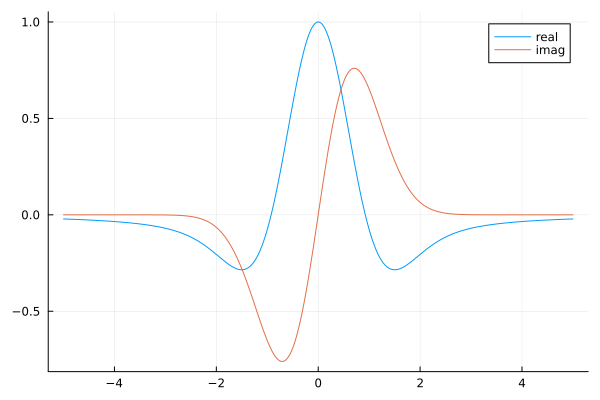

In [749]:
function W_val(z)
    #TODO Add special cases for small and large z???
    return 1. + 1im * z * sqrt(pi) * faddeeva(z)
end


function dW_dz(z)
    #TODO 
    #return 2im / sqrt(pi) - 2. *exp(-z^2) * z * erfc(- 1im * z)
    #return 2im / sqrt(pi) - 2. * z * faddeeva(z)
    #return 1im * z * sqrt(pi) * (2im / sqrt(pi) - 2. * z * faddeeva(z)) + 1im * sqrt(pi) * faddeeva(z)
    return 1im * sqrt(pi) * faddeeva(z) * (1 - 2*  z^2) - 2 * z
end

#------- to verify this is implemented correctly --------------------
#z_vals  = collect(range(-5,stop=5, length=10000))  #.+ 1.0im
z_vals  = collect(range(-5.0,stop=5.0, length=10000))  #.+ 1.0im
W_res = W_val.(z_vals);

dW_res = dW_dz.(z_vals)

plot(real.(z_vals), real.(W_res),label="real")
plot!(real.(z_vals), imag.(W_res),label="imag")
#---------------------------------------------------------------


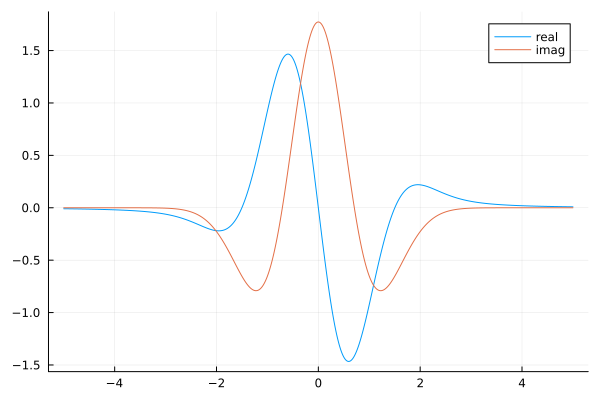

In [750]:
dW_res = dW_dz.(z_vals)

plot(real.(z_vals), real.(dW_res),label="real")
plot!(real.(z_vals), imag.(dW_res),label="imag")

In [751]:
#TODO we may rewrite all the eqautions so that omega_e refers to the frequency of each beam and not the total plasma frequency
#   This will allow us to write all the equations without the factor "1/2" in front of the electron terms
#   In general, it will allow us to built general two-stream dispersion relations

"
    full_dispertion_relation

compute the full dispersion relation for the warm electron-proton case
"
function full_dispertion_relation(omega, k, V0, v_t_e, v_t_i, debye_e, debye_i)
    z_plus  = (omega / k + V0) / (sqrt(2.) * v_t_e)
    z_minus = (omega / k - V0) / (sqrt(2.) * v_t_e)
    z_0     = (omega / k )     / (sqrt(2.) * v_t_i)
    
    electorn_part_1 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * W_val(z_plus)
    electorn_part_2 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * W_val(z_minus)
    ion_part        = 1.0 / ( debye_i * k )^2.0           * W_val(z_0)
    #TODO Make sure there is no factor sqrt(2) hiding somewhere 
    return 1. + electorn_part_1 + electorn_part_2 + ion_part
end

function full_dispertion_relation_derivative(omega, k, V0, v_t_e, v_t_i, debye_e, debye_i)
    z_plus  = (omega / k + V0) / (sqrt(2.) * v_t_e)
    z_minus = (omega / k - V0) / (sqrt(2.) * v_t_e)
    z_0     = (omega / k )     / (sqrt(2.) * v_t_i)

    extra_deriv_term_elec = (1.0 / k ) / (sqrt(2.) * v_t_e)
    extra_deriv_term_prot = (1.0 / k ) / (sqrt(2.) * v_t_e)

    
    electorn_part_1 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * dW_dz(z_plus)  * extra_deriv_term_elec
    electorn_part_2 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * dW_dz(z_minus) * extra_deriv_term_elec
    ion_part        = 1.0 / ( debye_i * k )^2.0           * dW_dz(z_0) * extra_deriv_term_prot
    #TODO Make sure there is no factor sqrt(2) hiding somewhere 
    return electorn_part_1 + electorn_part_2 + ion_part
end
"
    warm_elec_dispertion

compute the warm dispersion relation for the warm electron only case
"
function warm_elec_dispertion(omega, k, V0, v_t_e, debye_e)
    z_plus  = (omega / k + V0) / (sqrt(2.) * v_t_e)
    z_minus = (omega / k - V0) / (sqrt(2.) * v_t_e)
    
    electorn_part_1 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * W_val(z_plus)
    electorn_part_2 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * W_val(z_minus)
    return 1. + electorn_part_1 + electorn_part_2
end

function warm_elec_dispertion_derivative(omega, k, V0, v_t_e, debye_e)
    z_plus  = (omega / k + V0) / (sqrt(2.) * v_t_e)
    z_minus = (omega / k - V0) / (sqrt(2.) * v_t_e)

    extra_deriv_term = (1.0 / k ) / (sqrt(2.) * v_t_e)
    
    electorn_part_1 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * dW_dz(z_plus)     * extra_deriv_term
    electorn_part_2 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * dW_dz(z_minus)    * extra_deriv_term
    return electorn_part_1 + electorn_part_2
end
"
    cold_dispertion_relation

compute the cold dispersion relation for the cold electron-proton case
"
function cold_dispertion_relation(omega, k, V0, omega_e, omega_i)
    #TODO add special case for small V0*k?
    electorn_part_1 = 1.0/2.0 * omega_e^2  * ( 1 / (omega + V0 *k)^2 )
    electorn_part_2 = 1.0/2.0 * omega_e^2  * ( 1 / (omega - V0 *k)^2 )
    ion_part        =           omega_i^2        / omega^2
    return 1 - electorn_part_1 - electorn_part_2 - ion_part
end

function cold_dispertion_relation_derivative(omega, k, V0, omega_e, omega_i)
    #TODO add special case for small V0*k?
    electorn_part_1 =     omega_e^2  * ( 1 / (omega + V0 *k)^3 )
    electorn_part_2 =     omega_e^2  * ( 1 / (omega - V0 *k)^3 )
    ion_part        = 2*  omega_i^2        / omega^3
    return electorn_part_1 + electorn_part_2 + ion_part # note the changed sign
end
"
    cold_dispertion_relation

compute the cold dispersion relation for the cold electron only case
"
function cold_elec_dispertion_relation(omega, k, V0, omega_e)
    #TODO add special case for small V0*k?
    electorn_part_1 = 1.0/2.0 * omega_e^2  * ( 1 / (omega + V0 *k)^2 )
    electorn_part_2 = 1.0/2.0 * omega_e^2  * ( 1 / (omega - V0 *k)^2 )
    return 1 - electorn_part_1 - electorn_part_2
end

function cold_elec_dispertion_relation_derivative(omega, k, V0, omega_e)
    #TODO add special case for small V0*k?
    electorn_part_1 = omega_e^2  * ( 1 / (omega + V0 *k)^3 )
    electorn_part_2 = omega_e^2  * ( 1 / (omega - V0 *k)^3 )
    return electorn_part_1 + electorn_part_2 # note the changed sign in the derivative
end

#-------- function wrappers to be used by the newton-rhapson implementation ----------------
function function_wrapper_warm_full(omega, args...)
    return full_dispertion_relation(omega, args...)
end

function function_wrapper_warm_elec(omega, args...)
    return warm_elec_dispertion(omega, args...)
end

function function_wrapper_cold_full(omega, args...)
    return cold_dispertion_relation(omega, args...)
end

function function_wrapper_cold_elec(omega, args...)
    return cold_elec_dispertion_relation(omega, args...)
end

#----------------------------------------

function_wrapper_cold_elec (generic function with 1 method)

In [752]:
function numerical_derivative_imag(f, z; h=1e-5)
    h_val = h * 1.0im
    return (f(z + h_val) - f(z - h_val)) / (2.0*h_val)
end

function numerical_derivative_real(f, z, args; h=1e-5)
    h_val = h
    return (f(z + h_val,args...) - f(z - h_val,args...)) / (2.0*h_val)
end

function newton_raphson_complex_old(f, initial_guess, args, df; tol=1e-8, max_iterations=100, h=1e-5, step_size=1e0)
    z = initial_guess
    for i in 1:max_iterations
        fz = f(z,args...)


        dfz_real_num = numerical_derivative_real(f, z, args, h=h) 

        dfz_real = df(z, args...)

        #dfz_imag = numerical_derivative_imag(f, z, h=h)  #TODO highly unstable if I take a step both in real and imaginary plane

        #if abs(dfz_real) < tol
        #    return z, f(z), "derivative too small to continue"
        #    #println("Numerical derivative too small; division by zero or near-zero encountered")
        #end

        #----------------- change step size to avoid too large steps ------------
        step_real = (fz / dfz_real) 
        step = step_real #+ step_imag
        step_sign = sign(step)

        #if abs(step) > abs(z)
        #    step = step_sign * max(abs(z), 1.0) * step_size
        3#else
            step *= step_size
        #end
        #--------–--------–--------–--------–--------–--------–--------–

        #--------– Update value of z --------–--------–--------–
        z_new = z - step
        #--------–--------–--------–--------–--------–

        # Check for convergence
        if abs(z_new - z) < tol
            return z_new, f(z_new, args...), "Converged after $i iterations"
        end


        #println("---------")
        #println("num = ", dfz_real, " ", dfz_real_num)
        #println("step = ", fz / dfz_real, " ", step)
        #println("z     = ",z, " ", f(z,args...))
        #println("z_new = ",z_new, " ", f(z_new,args...))

        z = z_new




    end

    return z, f(z, args...),  "Stopped after reaching the maximum number of iterations"
end


newton_raphson_complex_old (generic function with 1 method)

In [753]:
function newton_raphson_complex(f, initial_guess, args, df; max_iterations=100, tol=1e-8)
    z = initial_guess
    z_all = []
    res_all = []
    df_all = []
    push!(z_all, z)
    push!(res_all, f(z,args...))


    step_redution_factor = 1.0
    real_osciallation_counter = 0
    imag_osciallation_counter = 0
    last_real_direction = 0
    last_imag_direction = 0


    large_step_counter = 0
    large_step_interval = 1


    for i in 1:max_iterations
        #println(" ")
        #println("Iteration ", i )
        fz = f(z,args...)

        dfz = df(z, args...)
        push!(df_all, dfz)

        step = fz / dfz


        if abs(step) / abs(z) < 1e-4 && large_step_counter > large_step_interval
            #println("Taking large")
            step = sign(step) * abs(z) * 1e-4
        end

        #println(" step - ", step / z)

        #--------– Update value of z --------–--------–--------–
        z_new = z - step * step_redution_factor

       # z_new = real(z_new) 
        #--------–--------–--------–--------–--------–


        #------------------ Check for oscillations ------------------------------------
        real_direction = sign(real(z_new - z) + 1e-15)
        imag_direction = sign(imag(z_new - z) + 1e-15)

        if real_direction ==  -last_real_direction
            #println("real --- ", real(z_new - z)," ", real_direction, " ", last_real_direction, " ", real_osciallation_counter)
            real_osciallation_counter += 1
        else
            real_osciallation_counter = 0
        end

        if imag_direction ==  -last_imag_direction
            #println("imag --- ", imag(z_new - z), " ", imag_direction, " ", last_imag_direction, " ", imag_osciallation_counter)
            imag_osciallation_counter += 1
        else
            imag_osciallation_counter = 0
        end

        if real_osciallation_counter > 5 || imag_osciallation_counter > 5
            #println("Oscillation detected")
            step_redution_factor *= 0.9
            real_osciallation_counter = 0
            imag_osciallation_counter = 0
        end
        last_real_direction = real_direction
        last_imag_direction = imag_direction
        #------------------------------------------------------------------------



        # Check for convergence
        push!(z_all, z_new)
        push!(res_all, f(z_new,args...))

        if abs(z_new - z) < tol && abs(fz) < 1e-6
            return z_new, f(z_new, args...), "Converged after $i iterations", z_all, res_all, df_all
        end
        z = z_new


        large_step_counter += 1
        #time_since_last_large += 1
    end

    return z, f(z, args...),  "Stopped after reaching the maximum number of iterations", z_all, res_all, df_all
end


newton_raphson_complex (generic function with 1 method)

0.5 --- 0.0 + 0.09805734174789381im
0.0

 + 0.0976888334011311im --- -2.9843351543989982e-5 + 0.0im --- Stopped after reaching the maximum number of iterations


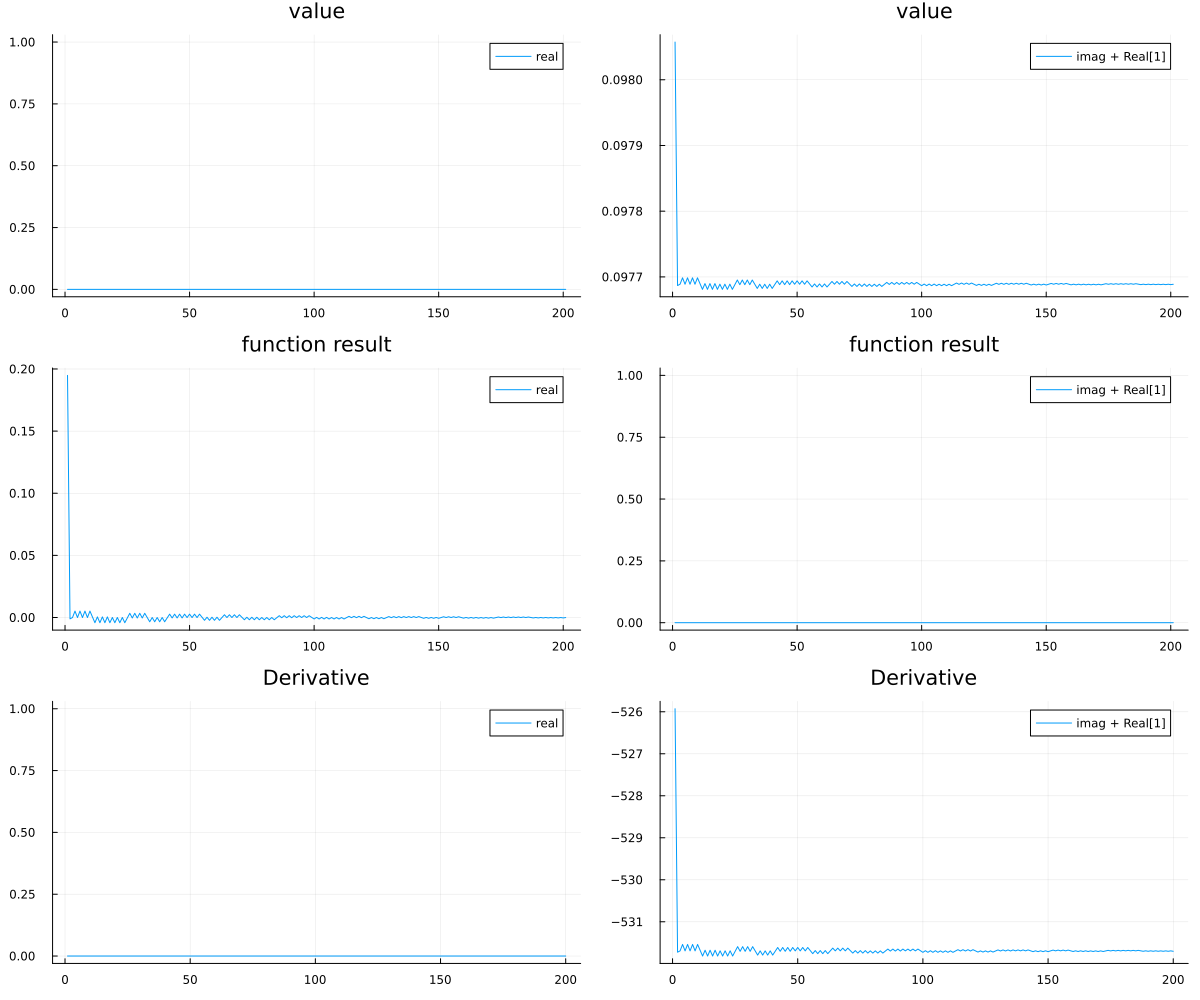

In [754]:
k_target = 0.5 #3.061530765382691
#k_target = 3.061530765382691

k_max_index = argmin(abs.(k_vals .- k_target))

k = k_vals[k_max_index]

args = (k, V_0, v_t_e, debye_e)
#omega = (0.5 + 0.0im) / omega_e
omega = cold_omega_3[k_max_index] 

println(k," --- ",  omega)
max_iterations = 200
omg, res, msg, z_all, res_all, df_all  = newton_raphson_complex(function_wrapper_warm_elec, omega , args, warm_elec_dispertion_derivative, max_iterations=max_iterations, tol=5e-7)


println(omg, " --- ",  res, " --- ", msg)
p1 = plot(real.(z_all), label="real", title="value")
p2 = plot(imag.(z_all),label="imag + Real[1]", title="value")

p3 = plot(real.(res_all), label="real", title="function result")
p4 = plot(imag.(res_all),label="imag + Real[1]", title="function result")

p5 = plot(real.(df_all), label="real", title="Derivative")
p6 = plot(imag.(df_all),label="imag + Real[1]", title="Derivative")
plot(layout=(3,2),p1,p2, p3, p4, p5, p6 ,size=(1200,1000))


In [755]:
#----------- Calculate the analytical solution for the cold electron only case -------–-------–-------–-------–-------–-------–-------–
k_vals           = collect(range(0.1,stop=2, length=2000)) * omega_e / V_0  
#Chose k values such that k * V_0 / omega_e is in the range [0, 2]

cold_omega_1 = -sqrt.( (-sqrt.(8. .* k_vals.^2 .* omega_e.^2 .* V_0^2 .+ omega_e^4 .+ 0.0im) .+ 2 .* k_vals.^2 .* V_0^2 .+ omega_e^2) ./ 2 .+ 0im)
cold_omega_2 = -sqrt.( (+sqrt.(8. .* k_vals.^2 .* omega_e.^2 .* V_0^2 .+ omega_e^4 .+ 0.0im) .+ 2 .* k_vals.^2 .* V_0^2 .+ omega_e^2) ./ 2 .+ 0im)
cold_omega_3 =  sqrt.( (-sqrt.(8. .* k_vals.^2 .* omega_e.^2 .* V_0^2 .+ omega_e^4 .+ 0.0im) .+ 2 .* k_vals.^2 .* V_0^2 .+ omega_e^2) ./ 2 .+ 0im)
cold_omega_4 =  sqrt.( (+sqrt.(8. .* k_vals.^2 .* omega_e.^2 .* V_0^2 .+ omega_e^4 .+ 0.0im) .+ 2 .* k_vals.^2 .* V_0^2 .+ omega_e^2) ./ 2 .+ 0im);


k_max_index = argmax(imag.(cold_omega_3))
k_max = k_vals[k_max_index] 
omega_max = cold_omega_3[k_max_index]
omega_max_scales = omega_max / omega_e
println("K range             = ", k_vals[1], " ", k_vals[end])
println("K_max               = ", k_max)
println("k_max / 2pi         = ", k_max / (2*pi))
println("K_max * V_0 / omega_e ", k_max * V_0 / omega_e)
println("k_max analytical    = ", sqrt(3/8) * omega_e / V_0)
println("omega_max           = ", omega_max)
println("omega_max / omega_e = ", omega_max_scales)
println("Sim Length          = ", 2 * pi / k_max * 2.)

K range             = 0.5 10.0
K_max               = 3.061530765382691
k_max / 2pi         = 0.48725775473856897
K_max * V_0 / omega_e 0.6123061530765382
k_max analytical    = 3.061862178478972
omega_max           = 0.0 + 0.3535533859335106im
omega_max / omega_e = 0.0 + 0.3535533859335106im
Sim Length          = 4.104603734984312


In [756]:
k_target = 0.6 #3.061530765382691
k_max_index = argmin(abs.(k_vals .- k_target))

k = k_vals[k_max_index]

args = (k, V_0, v_t_e, debye_e)
#omega = (0.5 + 0.0im) / omega_e
omega = cold_omega_4[k_max_index]

println(k," ",  omega)
max_iterations = 100
newton_raphson_complex(function_wrapper_warm_elec, omega , args, warm_elec_dispertion_derivative, max_iterations=max_iterations)# , #tol=1e-8)


0.599799899949975 1.0209737315060157 + 0.0im


(1.0210294709161418 + 0.0im, 2.9900526499204716e-12 + 0.0im, "Converged after 2 iterations", Any[1.0209737315060157 + 0.0im, 1.0210294661023216 + 0.0im, 1.0210294709161418 + 0.0im], Any[-0.0001137491952117875 + 0.0im, -9.822868740627655e-9 + 0.0im, 2.9900526499204716e-12 + 0.0im], Any[2.040908210536646 + 0.0im, 2.040555785167755 + 0.0im])

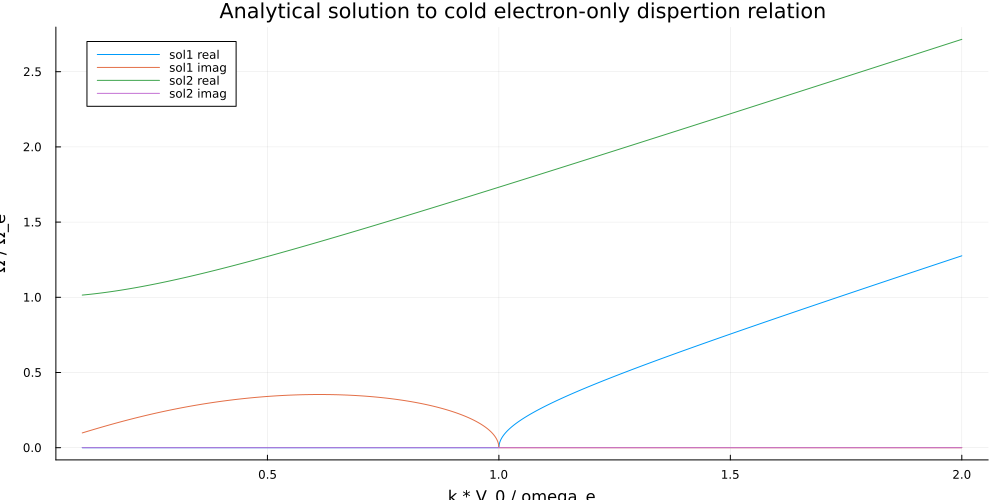

In [757]:
#-------– Plot the analytical solution for the positive omega cases -------–-------–-------–-------– 
plot(k_vals * V_0 / omega_e, real.(cold_omega_3 / omega_e), label="sol1 real", title="Analytical solution to cold electron-only dispertion relation",
    size=(1000,500), xlabel="k * V_0 / omega_e", ylabel = "Ω / Ω_e")
plot!(k_vals* V_0 / omega_e, imag.(cold_omega_3/ omega_e), label="sol1 imag")
plot!(k_vals* V_0 / omega_e, real.(cold_omega_4/ omega_e), label="sol2 real")
plot!(k_vals* V_0 / omega_e, imag.(cold_omega_4/ omega_e), label="sol2 imag")

In [758]:
cold_electron_branches = [[],[]]

for i in 1:size(k_vals,1)
    args_cold_elec = (k_vals[i], V_0, omega_e)
    res = function_wrapper_cold_elec(cold_omega_3[i], args_cold_elec...)

    if abs(res) < 1e-5
        push!(cold_electron_branches[1], ( cold_omega_3[i], k_vals[i], res))
    end 

    res = function_wrapper_cold_elec(cold_omega_4[i], args_cold_elec...)

    if abs(res) < 1e-5
        push!(cold_electron_branches[2], ( cold_omega_4[i], k_vals[i], res))
    end
end

In [759]:
function make_new_guess(branch_list, j , function_wrapper,function_deriv, args; search_type=1,  max_iterations=200, branch_step=1e-1, reversed=false)

    k = args[1]

    if reversed
        initial_guess = branch_list[j][1][1] 
    else
        initial_guess = branch_list[j][end][1]
    end


    #if search_type == 0
    #    initial_guess = initial_guess
    if search_type == 1
        initial_guess = initial_guess + branch_step * omega_e
    elseif search_type == 2
        initial_guess = initial_guess - branch_step * omega_e
    elseif search_type == 3
        initial_guess = initial_guess + branch_step * omega_e * 1im
    elseif search_type == 4
        initial_guess = initial_guess - branch_step * omega_e * 1im
    end



    res0, err0, msg0 = newton_raphson_complex(function_wrapper, initial_guess, args,   function_deriv ,max_iterations=max_iterations)

    #res0 = abs(real(res0)) + imag(res0) * 1im
    #if error is still too large, do not add it to the list
    if abs(err0) < 1e-5
        if (k > 10 || k < 0.5)
            println("ERROR - k out of range", k,  " intial initial_guess", initial_guess, " res ", res, " err ", err, " msg ", msg)
        end
        if reversed
            pushfirst!(branch_list[j],  (res0, k, err0))
        else
            push!(branch_list[j],  (res0, k, err0))
        end
    end

end 

make_new_guess (generic function with 1 method)

In [760]:
function make_initial_branches(function_wrap, function_deriv ,arg_static, k_vals, initial_guesses; max_iterations=200, k_cut=20.0, reversed=false)
    branch_list = [[] for i in 1:size(initial_guesses)[1]]
    
    k_size = size(k_vals)[1]
    if reversed
        k_cut = k_vals[end] - k_cut
    else
        k_cut = k_vals[1] + k_cut
    end
    cut_index = argmin(abs.(k_vals .- k_cut))

    #println("cut_index ", cut_index)


    if reversed
        for j in 1:size(initial_guesses)[1]

            i = size(initial_guesses[j],1)
            k = initial_guesses[j][i][2]

            while k > k_cut && i >= 1
                args = (k, arg_static...)
                initial_guess = initial_guesses[j][i][1]
                res, err, msg = newton_raphson_complex(function_wrap, initial_guess, args,   function_deriv ,max_iterations=max_iterations)

                if abs(err) < 1e-5
                    if (k > 10 || k < 0.5)
                        println("ERROR - k out of range", k,  " intial initial_guess", initial_guess, " res ", res, " err ", err, " msg ", msg)
                    end
                    pushfirst!(branch_list[j],  (res, k, err))
                end

                i -= 1
                if i >= 1
                    k = initial_guesses[j][i][2]
                end
            end
        end

    else
        for j in 1:size(initial_guesses)[1]

            i = 1
            k = initial_guesses[j][i][2]

            while k < k_cut && i <= size(initial_guesses[j],1)
                args = (k, arg_static...)
                initial_guess = initial_guesses[j][i][1]
                res, err, msg = newton_raphson_complex(function_wrap, initial_guess, args,   function_deriv ,max_iterations=max_iterations)

                if abs(err) < 1e-5
                    if (k > 10 || k < 0.5)
                        println("ERROR - k out of range", k,  " intial initial_guess", initial_guess, " res ", res, " err ", err, " msg ", msg)
                    end
                    push!(branch_list[j],  (res, k, err))
                end

                i += 1
                if i <= size(initial_guesses[j],1)
                    k = initial_guesses[j][i][2]
                end
            end
        end
    end

    return branch_list, cut_index
end

make_initial_branches (generic function with 1 method)

In [761]:
function find_matching_k(branch1, branch2, idx1, idx2, k1, k2)
    #println("input ", idx1, " ", idx2, " ", k1, " ", k2)

    new_idx1 = idx1
    new_idx2 = idx2

    new_k1 = k1
    new_k2 = k2
    while (abs(k1 - k2) > 1e-6) && idx1 < size(branch1, 1) && idx2 < size(branch2, 1)
        if k1 > k2
            idx2 += 1
            k2 = branch2[idx2][2]
        else
            idx1 += 1
            k1 = branch1[idx1][2]
        end
    end
    #println("output ", idx1, " ", idx2, " ", k1, " ", k2)
    idx1 = max(idx1, size(branch1, 1))
    idx2 = max(idx2, size(branch2, 1))
    return idx1, idx2, k1, k2
end 

find_matching_k (generic function with 1 method)

In [762]:
function find_branch_k_index(branch, k,debug=false)
    if debug
        println("searching for k ", k)
    end

    if k < branch[1][2] || k > branch[end][2]
        #error("k is outside the range of the branch")   
        return -1
    end

    left = 1
    right = size(branch,1)

    while left <= right
        if debug
            println("left ", left, " right ", right)
        end
        mid = (left + right) ÷ 2

        if abs(branch[mid][2] - k) < 1e-6
            if debug
                println("found k while testing", mid, " ", branch[mid][2], " ", k)
            end
            return mid
        elseif branch[mid][2] < k
            if debug
                println("k is larger than mid")
            end
            left = mid + 1
        else
            if debug
                println("k is smaller than mid")
            end
            right = mid - 1
        end
    end

    # Check which neighboring value is closest
    if abs(branch[left][2] - k) < abs(branch[right][2] - k) || right > size(branch,1)
        if debug
            println("left is closer ", left, " ", branch[left][2])
            println(" right was", right, " ", branch[right][2])
        end
        return left
    else
        if debug
            println("right is closer", right, " ", branch[right][2])
            println(" left was", left, " ", branch[left][2])
        end
        return right
    end
end


find_branch_k_index (generic function with 2 methods)

In [763]:
function remove_negative_branches(branches)
    new_branches = []
    for branch in branches
        if size(branch)[1] > 0
            #Check if a large area of the solution exist where the imaginary part of omega is negative and the real part is zero (or very small)
            #If so, remove the branch
            keep_branch = true
            

            res_vals = [branch[i][1] for i in 1:size(branch)[1]]
            #---------- remove branch if it contains negative real value of omega ----------------
            if minimum(real.(res_vals)) < - 1e-5 
                keep_branch = keep_branch && false
            end

            for i in 1:size(branch)[1]
                if imag(branch[i][1]) < - 1e-5 && abs.(real(branch[i][1])) < 1e-5
                    keep_branch = keep_branch && false
                end
            end


            if keep_branch
                push!(new_branches, branch)
            end
            
        end
    end
    return new_branches
end

remove_negative_branches (generic function with 1 method)

In [764]:
"""
    prune_branches

    Prunes the branches in the branch_list based on the difference in k values.
    Removes branches with large differences in k values and removes duplicate branches.

    Args:
    - branch_list: List of branches, where each branch is a list of tuples (res, k, err).
    - k_large_diff: Threshold for the difference in k values to prune branches.
    - reversed: Boolean indicating if the branches are in reverse order.

    Returns:
    - pruned_branch_list: List of pruned branches.

"""
function prune_branches(branch_list, k_large_diff, tol=1e-4)
    pruned_branch_list = []
    #First, remove all branches will large differences in k values
    for branch in branch_list
        if size(branch,1) == 0
            continue
        end

        k_values = [b[2] for b in branch]
        res_values = [b[1] for b in branch]
        k_diff = diff(k_values)
        res_diff = diff(res_values)

        if any(abs.(k_diff) .> k_large_diff) || any(real.(abs.(res_diff)) .> 1e-1 * omega_e)  || any(imag.(abs.(res_diff)) .> 1e-1 * omega_e)  # Check if any absolute difference in k values is larger than the threshold
            continue  # Skip this branch if it has large differences in k values
        end
        push!(pruned_branch_list, branch)
    end


    duplciate = falses((size(pruned_branch_list,1),size(pruned_branch_list,1)))

    for i in 1:size(pruned_branch_list,1)
        for j in i+1:size(pruned_branch_list,1)

            k_min1 = pruned_branch_list[i][1][2]
            k_max1 = pruned_branch_list[i][end][2]
            k_min2 = pruned_branch_list[j][1][2]
            k_max2 = pruned_branch_list[j][end][2]



            if i == j || k_max1 < k_min2 || k_max2 < k_min1
                continue
            end

            idx1 = 1 # start a couple of indices in to avoid the edge effects
            diff_arr = []
    
            while idx1 < size(pruned_branch_list[i],1)
                k1 = pruned_branch_list[i][idx1][2]

                idx2 = find_branch_k_index(pruned_branch_list[j], k1, false)

                
                if idx2 != -1
                    k2 = pruned_branch_list[j][idx2][2]
                    difference = pruned_branch_list[i][idx1][1] - pruned_branch_list[j][idx2][1]
                    
                    if abs(k1 - k2) < 1e-6
                        push!(diff_arr, abs(difference))
                    end
                end
                idx1 +=1
            end
            #println("Max diff ", i, " ", j, " ", maximum(diff_arr))
            if maximum(diff_arr) < tol
                duplciate[i,j] = true
            end
        end
    end



    final_list = []
    for i in 1:size(duplciate,1)
        if any(duplciate[:,i])
            continue
        end
        push!(final_list, branch_list[i])
    end

    #final_list = remove_negative_branches(final_list)

    return final_list
end


prune_branches

In [765]:
function find_branch_solutions(function_wrap, function_deriv ,arg_static, k_vals, initial_guesses, max_iterations=200, branch_step=1e-1, k_cut=20.0, large_k_diff_remove=5.0)
    k_size = size(k_vals)[1]

    

    combined_branch_list = []

    #-------- first make a gueses using the previous as inital guess for all branches ----------
   # println("intial guess ")
    intial_list, cut_index = make_initial_branches(function_wrap, function_deriv ,arg_static, k_vals, initial_guesses, max_iterations=max_iterations, k_cut=k_vals[end]- k_vals[1])
    #println("intial guess rev")
    intial_list_rev, cut_index_rev = make_initial_branches(function_wrap, function_deriv ,arg_static, k_vals, initial_guesses, max_iterations=max_iterations, k_cut=k_vals[end]- k_vals[1], reversed=true)
   # println("after rev")
    combined_branch_list = vcat(combined_branch_list, intial_list)
    combined_branch_list = vcat(combined_branch_list, intial_list_rev)

    #println("prune initial")
   combined_branch_list = prune_branches(combined_branch_list, large_k_diff_remove,1e-4)
    #------------------------------------------------------------------------------------

    for search_type in 1:4
       # println("search type", search_type)
        # Search through existing branches using only the start of the initial guesses to start the branches 
        if search_type == 1
           # println("make initial 1")
            branch_list, cut_index = make_initial_branches(function_wrap, function_deriv ,arg_static, k_vals, initial_guesses, max_iterations=max_iterations, k_cut=k_cut)
            branch_list_rev, cut_index_rev = make_initial_branches(function_wrap,function_deriv ,arg_static, k_vals, initial_guesses, max_iterations=max_iterations, k_cut=k_cut,reversed=true)
        else
            #println("make initial other")
            branch_list, cut_index = make_initial_branches(function_wrap,function_deriv ,arg_static, k_vals, combined_branch_list, max_iterations=max_iterations, k_cut=k_cut)
            branch_list_rev, cut_index_rev = make_initial_branches(function_wrap, function_deriv ,arg_static, k_vals, combined_branch_list, max_iterations=max_iterations, k_cut=k_cut,reversed=true)   
        end




        for i in cut_index+1:k_size
            k = k_vals[i]
            args = (k, arg_static...)
            for j in 1:size(branch_list)[1]
                if size(branch_list[j],1) > 0
                    make_new_guess(branch_list, j, function_wrap,function_deriv, args, search_type=search_type, max_iterations=max_iterations, branch_step=branch_step)
                end
            end

        end

        for i in cut_index_rev-1:-1:1
            k = k_vals[i]
            args = (k, arg_static...)
            for j in 1:size(branch_list_rev)[1]
                if size(branch_list_rev[j],1) > 0
                    make_new_guess(branch_list_rev, j, function_wrap,function_deriv, args, search_type=search_type, max_iterations=max_iterations, branch_step=branch_step, reversed=true)
                end 
            end

        end

        #Combine the branches and remove dulplicates 
        combined_branch_list = vcat(combined_branch_list, branch_list)
        combined_branch_list = vcat(combined_branch_list, branch_list_rev)
        #println("search_type", search_type, " Number of branches before pruning", size(combined_branch_list,1))

        #for branch_list in combined_branch_list
        #    complete

        #println("prune search ", search_type)
        combined_branch_list = prune_branches(combined_branch_list, large_k_diff_remove,1e-4)

       # println("search_type", search_type, " Number of branches after pruning", size(combined_branch_list,1))

    end
    

    #prune one last time 
    combined_branch_list = prune_branches(combined_branch_list, large_k_diff_remove,1e-4)
    return combined_branch_list
end




function plot_branches(branches)
    # Initialize your plot object here, before the loop.
    # Use an empty plot as a starting point.
    p1 = plot(title="Omega vs. k", xlabel="k", ylabel="Omega / omega_e", legend=:topright)


    p2 = plot(title="Dispertion value for solution", xlabel="k", ylabel="", legend=:topright)

    for j in 1:size(branches)[1]
        omega_vals = [branches[j][i][1] for i in 1:size(branches[j])[1]]
        kvals      = [branches[j][i][2] for i in 1:size(branches[j])[1]]
        error_vals = [branches[j][i][3] for i in 1:size(branches[j])[1]]

        # Add each branch to the plot. Use unique labels for each branch for clarity.
        plot!(p1, kvals * V_0 / omega_e, real.(omega_vals) / omega_e, label="Re(omega) Branch $j")
        plot!(p1, kvals * V_0 / omega_e, imag.(omega_vals) / omega_e, label="Im(omega) Branch $j", linestyle=:dash)


        plot!(p2, kvals * V_0 / omega_e, abs.(error_vals), label="error Branch $j")

    end

    # Display the plot
    p = plot(p1,p2, size=(1400,600))
     display(p)
end 


plot_branches (generic function with 1 method)

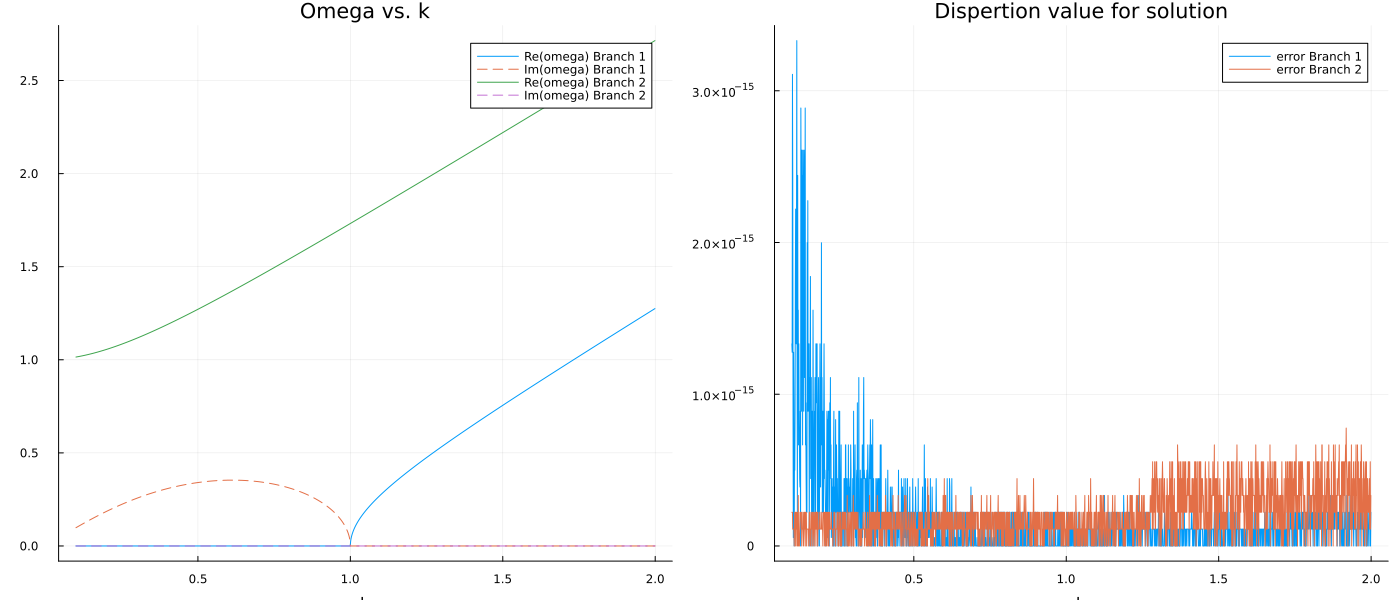

In [766]:
arg_static = ( V_0, omega_e)

initial_guesses = cold_electron_branches



branches_cold_elec = find_branch_solutions(function_wrapper_cold_elec,cold_elec_dispertion_relation_derivative , arg_static,  k_vals, initial_guesses, 100,1e-2,0.6,0.1)
branches_cold_elec = remove_negative_branches(branches_cold_elec)
plot_branches(branches_cold_elec)


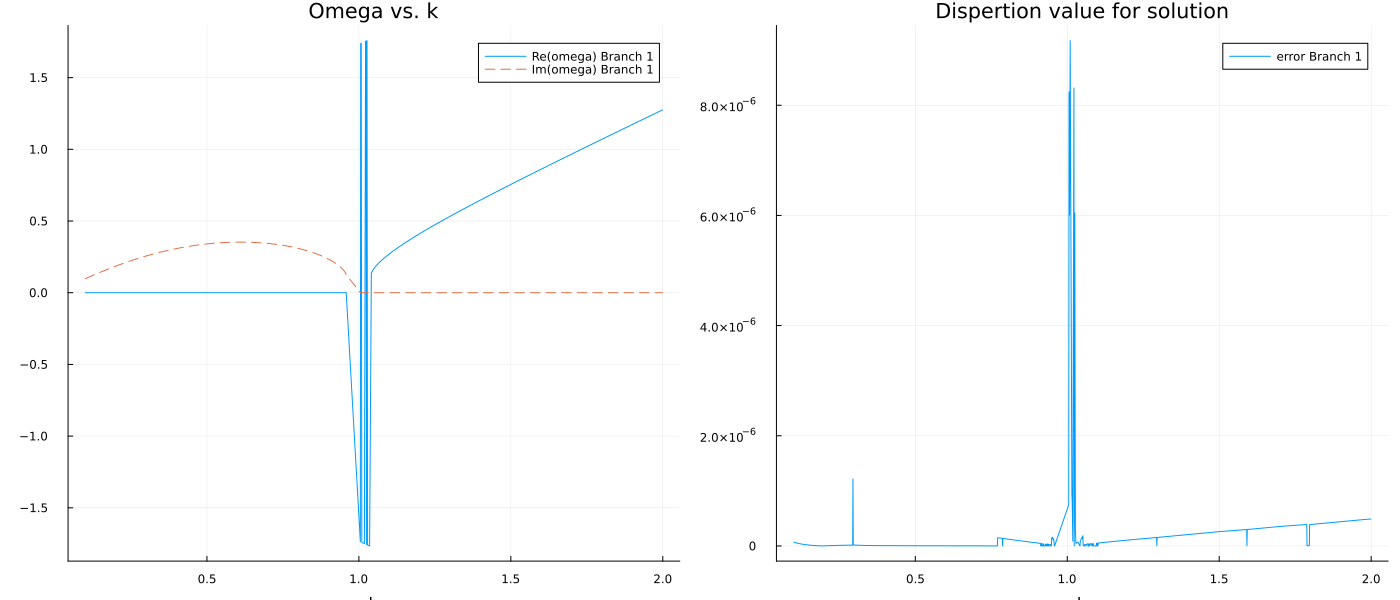

In [767]:
#branches = [[]]
arg_static = ( V_0, omega_e, omega_p)
#initial_guesses = sol_cold1 #[sol_cold1, sol_cold2]
#initial_guesses = [sol_cold1, sol_cold2]

initial_guesses = cold_electron_branches

branches_cold_full = find_branch_solutions(function_wrapper_cold_full,cold_dispertion_relation_derivative, arg_static,  k_vals, initial_guesses, 300,1e-2,0.6,0.2)
#branches_cold_full = remove_negative_branches(branches_cold_full)
plot_branches(branches_cold_full)

In [737]:

ks = [branches_cold_full[1][i][2] for i in 1:size(branches_cold_full[1],1)]
res = [branches_cold_full[1][i][1] for i in 1:size(branches_cold_full[1],1)]


k_max_index = argmax(imag.(res))
k_max = k_vals[k_max_index] 
omega_max = res[k_max_index]
omega_max_scales = omega_max / omega_e

println("Full cold-case")
println("K range             = ", k_vals[1], " ", k_vals[end])
println("K_max               = ", k_max)
println("k_max / 2pi         = ", k_max / (2*pi))
println("omega_max           = ", omega_max)
println("omega_max / omega_e = ", omega_max_scales)

Full cold-case
K range             = 0.5 10.0
K_max               = 3.056778389194597
k_max / 2pi         = 0.4865013905768016
omega_max           = 0.0 + 0.35278223606444464im
omega_max / omega_e = 0.0 + 0.35278223606444464im


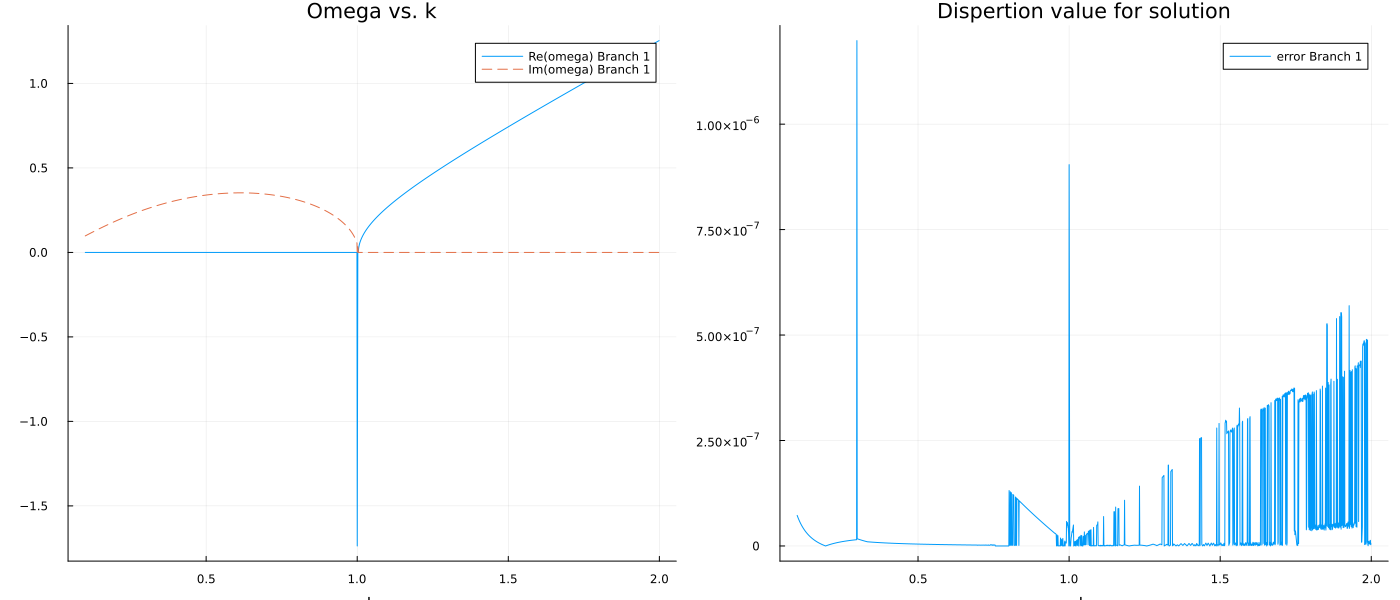

In [769]:
arg_static = (V_0, v_t_e, debye_e)
#initial_guesses = branches_cold_full
#initial_guesses = branches_cold_full

initial_guesses = branches_cold_elec

branches_warm_elec = find_branch_solutions(function_wrapper_warm_elec, warm_elec_dispertion_derivative , arg_static,  k_vals, initial_guesses, 300,1e-2,0.6, 0.2)
plot_branches(branches_warm_elec)

In [771]:

ks = [branches_warm_elec[1][i][2] for i in 1:size(branches_warm_elec[1],1)]
res = [branches_warm_elec[1][i][1] for i in 1:size(branches_warm_elec[1],1)]


k_max_index = argmax(imag.(res))
k_max = k_vals[k_max_index] 
omega_max = res[k_max_index]
omega_max_scales = omega_max / omega_e

println("K range             = ", k_vals[1], " ", k_vals[end])
println("K_max               = ", k_max)
println("k_max / 2pi         = ", k_max / (2*pi))
println("omega_max           = ", omega_max)
println("omega_max / omega_e = ", omega_max_scales)

K range             = 0.5 10.0
K_max               = 3.066283141570785
k_max / 2pi         = 0.48801411890033636
omega_max           = 0.0 + 0.35254860400448845im
omega_max / omega_e = 0.0 + 0.35254860400448845im


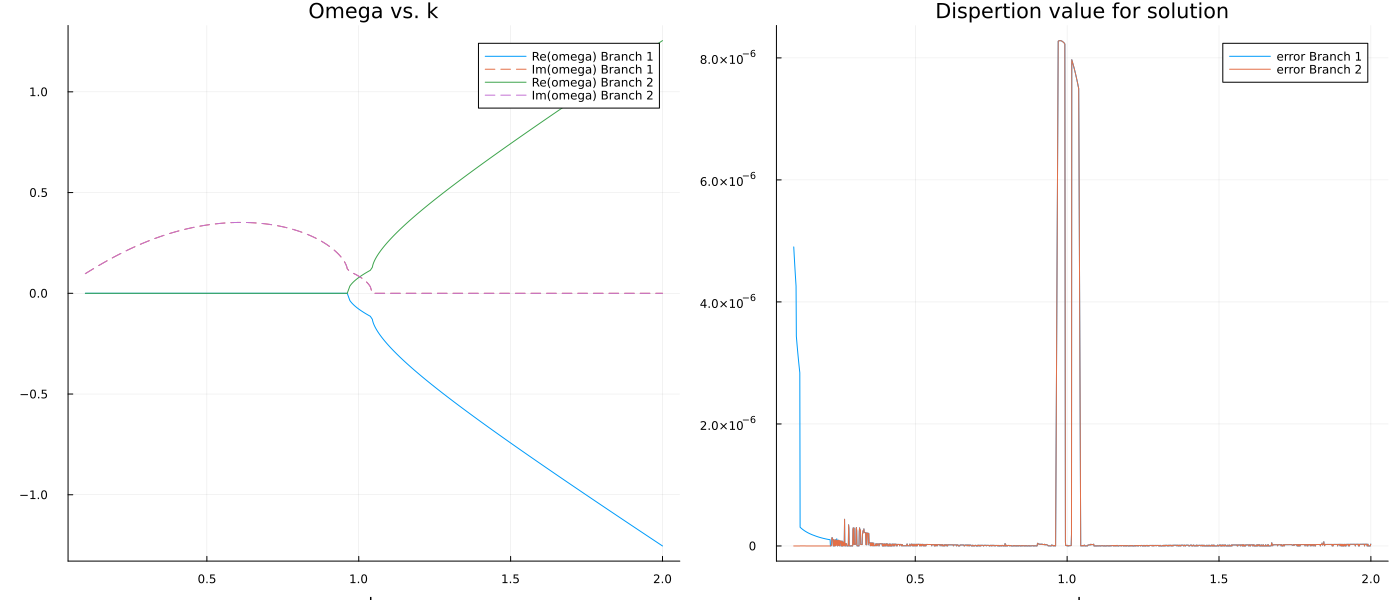

In [772]:
arg_static = (V_0, v_t_e, v_t_p, debye_e, debye_i)
#initial_guesses = branches_cold_full
initial_guesses = branches_warm_elec

branches_warm_full = find_branch_solutions(function_wrapper_warm_full, full_dispertion_relation_derivative,  arg_static,  k_vals, initial_guesses, 500,1e-2,0.6,0.2)
plot_branches(branches_warm_full)


In [773]:

ks = [branches_warm_full[1][i][2] for i in 1:size(branches_warm_full[1],1)]
res = [branches_warm_full[1][i][1] for i in 1:size(branches_warm_full[1],1)]


k_max_index = argmax(imag.(res))
k_max = k_vals[k_max_index] 
omega_max = res[k_max_index]
omega_max_scales = omega_max / omega_e

println("Full warm case")
println("K range             = ", k_vals[1], " ", k_vals[end])
println("K_max               = ", k_max)
println("k_max / 2pi         = ", k_max / (2*pi))
println("omega_max           = ", omega_max)
println("omega_max / omega_e = ", omega_max_scales)

Full warm case
K range             = 0.5 10.0
K_max               = 3.061530765382691
k_max / 2pi         = 0.48725775473856897
omega_max           = 1.3910250650506368e-9 + 0.351775579993647im
omega_max / omega_e = 1.3910250650506368e-9 + 0.351775579993647im


In [774]:
k_cold = sqrt(3/8) * omega_e / V_0

3.061862178478972

In [775]:
# Shift in growth rate for v_thermal = 0.05*V_0
growth_rate_shift = (0.351775579993647 -  0.3535533859335106) /  0.3535533859335106

#shifht in k for the same 
k_shifht = (3.061530765382691 - k_cold) / k_cold

println(growth_rate_shift)
println(k_shifht)

println("")
println(growth_rate_max)

-0.00502839460911833
-0.00010823906399532914

-0.013932787575614938


In [744]:
# Shift in growth rate for v_thermal = 0.05*V_0
growth_rate_shift = (0.3390310884727218 -  0.3535533859335106) /  0.3535533859335106
growth_rate_max  = (0.3486274017106596 -  0.3535533859335106) /  0.3535533859335106

#shifht in k for the same 
k_shifht = (2.586293146573287 - k_cold) / k_cold

println(growth_rate_shift)
println(k_shifht)

println("")
println(growth_rate_max)

-0.041075260593091543
-0.1553201954184403

-0.013932787575614938


In [266]:
(2.586293146573287 - k_cold) / k_cold

-0.1553201954184403

In [259]:
k_vals[540]

3.061530765382691

In [ ]:
temp_scale = 1.2

v_t_e_new = v_t_e * temp_scale
v_t_p_new =  v_t_p*temp_scale
debye_e_new = v_t_e_new / omega_e
debye_i_new = v_t_p_new / omega_p

arg_static = (V_0 , v_t_e_new, v_t_p_new, debye_e_new, debye_i_new)
#initial_guesses = branches_cold_full
#initial_guesses = branches_warm_full[1:3]
initial_guesses = branches_warm_full

branches_warm_full_v02 = find_branch_solutions(function_wrapper_warm_full, arg_static,  k_vals, initial_guesses, 300, 1e-5,5e-2,40)
plot_branches(branches_warm_full_v02)
